# Authentication

In [234]:
import datetime as dt 
import numpy as np
import requests
import json
import warnings
import pandas as pd  
import math
from scipy.optimize import least_squares
from scipy.optimize import minimize
import matplotlib.pyplot as plt


from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
warnings.filterwarnings("ignore")

#Get the token to access vMM information  -- via API
def authentication(username,password,aosip):
    url_login = "https://" + aosip + ":4343/v1/api/login"
    payload_login = 'username=' + username + '&password=' + password
    headers = {'Content-Type': 'application/json'}
    get_uidaruba = requests.post(url_login, data=payload_login, headers=headers, verify=False)

    if get_uidaruba.status_code != 200:
        print('Status:', get_uidaruba.status_code, 'Headers:', get_uidaruba.headers,'Error Response:', get_uidaruba.reason)
        uidaruba = "error"

    else:
        uidaruba = get_uidaruba.json()["_global_result"]['UIDARUBA']
        return uidaruba

#show command
def show_command(aosip,uidaruba,command):
    url_login = 'https://' + aosip + ':4343/v1/configuration/showcommand?command='+command+'&UIDARUBA=' + uidaruba
    aoscookie = dict(SESSION = uidaruba)
    AOS_response = requests.get(url_login, cookies=aoscookie, verify=False)
    
    if AOS_response.status_code != 200:
        print('Status:', AOS_response.status_code, 'Headers:', AOS_response.headers,'Error Response:', AOS_response.reason)
        AOS_response = 'error'

    else:
        AOS_response = AOS_response.json()
        
    return AOS_response

# Username, password, IP to login Aruba Controller
username='apiUser'
password='x564#kdHrtNb563abcde'
vMM_aosip='140.118.151.248'

# Input params

In [295]:
# Dict of AP coordinate for all floor in IY building
ref_aps_dict_all = {
    '1F': {'1F_AP01': (16.84, 13.98), '1F_AP03': (19.59, 1.51), '1F_AP05': (23.9, 9.38), '1F_AP07': (33.62, 7.42)},
    '2F': {'2F_AP01': (1.07, 6.59), '2F_AP03': (10.45, 11.97), '2F_AP05': (10.55, 4.26)},
    '3F': {'3F_AP01': (11.24, 2.41),'3F_AP03': (17.38, 12.13),'3F_AP05': (20.50, 3.32),'3F_AP07': (25.42, 12.97), '3F_AP09': (31.08, 4.85)},
    '4F': {'4F_AP01': (16.82, 4.96),'4F_AP03': (16.22, 12.93),'4F_AP05': (31.53, 4.70),'4F_AP07': (26.90, 13.09)},
    '5F': {'5F_AP01': (10.78, 3.11),'5F_AP03': (13.07, 12.29),'5F_AP05': (15.89, 3.18),'5F_AP07': (21.97, 12.21),'5F_AP09': (27.63, 8.02)},
    '6F': {'6F_AP01': (10.58, 14.12),'6F_AP03': (19.17, 14.40),'6F_AP05': (25.32, 14.18),'6F_AP07': (13.14, 4.25),'6F_AP09': (28.51, 6.45)},
    '7F': {'7F_AP01': (14.09, 3.31),'7F_AP03': (15.77, 12.25),'7F_AP05': (20.86, 3.33),'7F_AP07': (23.01, 12.35),'7F_AP09': (28.74, 4.07)},
    '8F': {'8F_AP01': (13.80, 3.22),'8F_AP03': (14.56, 12.04),'8F_AP05': (19.88, 3.17),'8F_AP07': (22.64, 12.11),'8F_AP09': (31.58, 3.25)},
    '9F': {'9F_AP01': (3.95, 11.37),'9F_AP03': (26.43, 4.12),'9F_AP05': (14.33, 3.80),'9F_AP07': (27.07, 11.01)},
    '10F': {'10F_AP01': (15.56, 3.99),'10F_AP03': (13.99, 12.02),'10F_AP05': (27.53, 3.01),'10F_AP07': (27.43, 12.32)}
}

# Input a dict of ref APs in a floor/room
ref_aps_dict = ref_aps_dict_all['1F']
ref_aps = list(ref_aps_dict.keys())  # Extracting keys (AP names)
ref_aps_coords = list(ref_aps_dict.values())  # Extracting values (AP coordinates)

# Get PL(d_ij), d_ij

## Get d_ij

In [296]:
def dis_ref_ap(ref_aps, ref_aps_coords):
    # Calculate distances between APs
    distance_data = []
    for i in range(len(ref_aps_coords)):
        for j in range(i + 1, len(ref_aps_coords)):
            distance = math.sqrt((ref_aps_coords[i][0] - ref_aps_coords[j][0])**2 + 
                                 (ref_aps_coords[i][1] - ref_aps_coords[j][1])**2)
            distance_data.append({'i': ref_aps[i], 'j': ref_aps[j], 'd (m)': distance})

    # Create DataFrame
    df_distance = pd.DataFrame(distance_data)
    return df_distance

# Test result
df_distance = dis_ref_ap(ref_aps, ref_aps_coords)
df_distance

,i,j,d (m)
0,1F_AP01,1F_AP03,12.769628
1,1F_AP01,1F_AP05,8.426363
2,1F_AP01,1F_AP07,18.016714
3,1F_AP03,1F_AP05,8.972904
4,1F_AP03,1F_AP07,15.223961
5,1F_AP05,1F_AP07,9.915644


In [297]:
# Login Aruba
token = authentication(username, password, vMM_aosip)
    
def get_PL(df_distance, ref_aps, vMM_aosip, token):
    
    # Declare dict of list of Path Loss
    df_dict = {} 

    for ap in ref_aps:
        try:
            command = 'show+ap+arm+state+ap-name+IY_'+ap
            list_ap_database = show_command(vMM_aosip, token, command)
            df_dict[ap] = pd.DataFrame(list_ap_database['Neighbor Data'])
            df_dict[ap] = df_dict[ap][['Name', 'Path Loss (dB)']]
            df_dict[ap]['Name'] = df_dict[ap]['Name'].str.replace('IY_', '', regex=False)
            df_dict[ap] = df_dict[ap][df_dict[ap]['Name'].str.startswith('{}'.format(ap[:2]))]
            df_dict[ap].drop_duplicates(subset='Name', keep='first', inplace=True)
            df_dict[ap]['j'] = df_dict[ap]['Name'].str.replace('IY_', '', regex=False)
            df_dict[ap]['i'] = ap
            df_dict[ap].drop(columns=['Name'], inplace=True)
        except Exception:
            pass

    print('Path Loss (dB) from neighbor APs in {} : '.format(ap[:2]))

    df = pd.concat(df_dict.values(), ignore_index=True)

    # Create a set to keep track of pairs that have been encountered
    pair_set = set()

    # List to store indices to keep
    indices_to_keep = []

    # Iterate through rows of the final DataFrame
    for index, row in df.iterrows():
        if row['i'] in ref_aps and row['j'] in ref_aps:
            pair = tuple(sorted([row['i'], row['j']]))
            if pair not in pair_set:
                pair_set.add(pair)
                indices_to_keep.append(index)

    # Keep only the rows with selected indices
    df = df.loc[indices_to_keep]

    # Merge the filtered DataFrame with the distance DataFrame based on columns 'i' and 'j'
    df_PL = pd.merge(df, df_distance, on=['i', 'j'], how='left')

    # Convert 'Path Loss (dB)' column to integer
    df_PL['Path Loss (dB)'] = df_PL['Path Loss (dB)'].astype(int)

    # Reorder columns as 'i', 'j', 'Path Loss', 'd'
    ordered_columns = ['i', 'j', 'Path Loss (dB)', 'd (m)']
    df_PL = df_PL[ordered_columns]
    return df_PL

# Test result
df_PL = get_PL(df_distance, ref_aps, vMM_aosip, token)
df_PL

Path Loss (dB) from neighbor APs in 1F : 


,i,j,Path Loss (dB),d (m)
0,1F_AP01,1F_AP03,82,12.769628
1,1F_AP01,1F_AP07,86,18.016714
2,1F_AP01,1F_AP05,74,8.426363
3,1F_AP03,1F_AP07,85,15.223961
4,1F_AP03,1F_AP05,75,8.972904
5,1F_AP05,1F_AP07,69,9.915644


# Calibrate C, n

In [298]:
### Use known PL(d_ij) and d_ij from Aruba APs to calibrate C and n.

def cal_C_n(df_PL):
    # Define path loss functions in eq. 9.
    # x[0] stands for PL(d_ij) and x[1] stands for d_ij in every two APs i,j
    def path_loss_function(x, distance):
        return x[0] + 10 * x[1] * math.log10(distance)

    # Define the objective function J
    def objective_function(x):
        error_sum = 0
        for distance, rssi in data:
            estimated_rssi = path_loss_function(x, distance)
            error_sum += (estimated_rssi - rssi) ** 2
        return error_sum
    
    # Data take only PL(d_ij), d_ij from function 1
    data = df_PL[['d (m)', 'Path Loss (dB)']].apply(tuple, axis=1).tolist()
    
    # Minimize the objective function J
    initial_guess = [0, 0]
    result = minimize(objective_function, initial_guess)

    # Extract the optimized values of C and n
    C = result.x[0]
    n = result.x[1]

    return C, n

# Test result
C, n = cal_C_n(df_PL)
print("Optimized C:", C)
print("Optimized n:", n)

Optimized C: 29.979880860235905
Optimized n: 4.535102264872092


# Get RSSI_ij, d_ij

In [299]:
# Verified rogue APs
rogue_ap = "LouisaCoffee" # Rogue AP name
rogue_ap_real_coords = (22.63, 8.14) # Rogue AP real coordinate (x_ir,y_ir) from location results

## Get d_ij

In [300]:
def dis_rogue_ap(ref_aps, ref_aps_coords, rogue_ap_real_coords):
    # List of d_ij between rogue AP and ref AP
    distances = []
    for j, ref_coord in zip(ref_aps, ref_aps_coords):
        distance = math.sqrt((rogue_ap_real_coords[0] - ref_coord[0])**2 + (rogue_ap_real_coords[1] - ref_coord[1])**2)
        distances.append(distance)

    # Create DataFrame
    data = {'i': [rogue_ap] * len(ref_aps),
            'j': ref_aps,
            'd (m)': distances}

    df_distance = pd.DataFrame(data)
    return df_distance

# Test result
df_distance = dis_rogue_ap(ref_aps, ref_aps_coords, rogue_ap_real_coords)
df_distance

,i,j,d (m)
0,LouisaCoffee,1F_AP01,8.223728
1,LouisaCoffee,1F_AP03,7.293730
2,LouisaCoffee,1F_AP05,1.774965
3,LouisaCoffee,1F_AP07,11.013560


# Get RSSI_ij

In [301]:
# =============================================================================
# Retrieve and process RSSI

# Login Aruba
token = authentication(username, password, vMM_aosip)

def rss_retrieve(df_distance, ref_aps, rogue_ap, vMM_aosip, token):    
    df = {} # Initiate RSSI dataframe for a floor
    
    # Login controller function
    token = authentication(username, password, vMM_aosip)
    
    # For each Aruba AP in the ref_aps list, retrieve rogue AP's RSSI data from the Aruba AP.
    for ap in ref_aps:
        command = 'show+ap+monitor+ap-list+ap-name+IY_'+ap # Run CLI command to retrieve RSSI data
        list_ap_database = show_command(vMM_aosip, token, command)
        df[ap] = pd.DataFrame(list_ap_database['Monitored AP Table'])
        df[ap]['curr-rssi'] = pd.to_numeric(df[ap]['curr-rssi'])
        df[ap] = df[ap][(df[ap]['ap-type']!='valid')
                                            &(df[ap]['essid']!='eduroam')
                                            &(df[ap]['essid']!='sensor')
                                            &(df[ap]['essid']!='NTUST-PEAP')
                                            &(df[ap]['essid']!='NTUST-UAM')][['essid','bssid','curr-rssi']]
        df[ap] = df[ap][(df[ap]['curr-rssi']>0)]

        ap_int_lists = []

        # For each AP, separate RSSI from Aruba APs (max Aruba APs is 5 each floor => list [0, 4])
        for ap_idx in [0, 1, 2, 3, 4]:
            try:
                ap_int = df[ref_aps[ap_idx]]['bssid']
            except Exception:
                ap_int = None
            ap_int_lists.append(ap_int)
        
        # Group all AP with their RSSI in a floor
        ap_int_combinations = [
            [ap_int_lists[0], ap_int_lists[1]],
            [ap_int_lists[2], ap_int_lists[3]],
            [ap_int_lists[4]]
        ]

        ap_all_int = []

        for ap_int_comb in ap_int_combinations:
            try:
                combined_int = pd.concat(ap_int_comb).reset_index(drop=True).drop_duplicates()
                ap_all_int.append(combined_int)
            except Exception:
                pass
        
        # Create a bssid list of rogue APs and save as ap_all
        ap_all_int = pd.concat(ap_all_int).reset_index(drop=True)
        df_rssi = pd.DataFrame(ap_all_int).reset_index(drop=True)
    
    # Add essid, ap type, channel, floor, Aruba AP number columns to dataframe
    df_rssi['essid'] = ''
    for i in range(len(ref_aps)):
        try:
            df_rssi[ref_aps[i][-4:]] = None
        except Exception:
            pass
    df_rssi['mon AP number'] = None
    
    # Count Aruba AP number and add essid, ap-type, channel from df to df_rssi
    for i in range(len(df_rssi)):
        no_ap = 0

        for ap in ref_aps:
            try:
            # Get essid
                df_rssi['essid'][i] = list(df[ap][(df[ap]['bssid']==df_rssi['bssid'][i])]['essid'])[0]
            # Get rssi
                if df[ap]['bssid'].str.contains(df_rssi['bssid'][i]).any():
                    df_rssi[ap[-4:]][i] = -list(df[ap][df[ap]['bssid']==df_rssi['bssid'][i]]['curr-rssi'])[0] 
                    no_ap+=1
            except Exception:
                pass
        df_rssi['mon AP number'][i] = no_ap

    # Rearrange df_rssi and add floor
    df_rssi = df_rssi[(df_rssi['mon AP number']>1)].sort_values('essid').reset_index(drop=True).drop_duplicates()
    df_rssi.drop(columns=['mon AP number'], inplace=True)
    new_columns = [col.replace('AP', '{}_AP'.format(ap[:2])) for col in df_rssi.columns]
    df_rssi.columns = new_columns
    df_rssi = df_rssi[df_rssi['essid']==rogue_ap].tail(1)
    # df_rssi = df_rssi.dropna(subset=['rssi'])
    df_rssi = df_rssi.drop(columns=['bssid', 'essid']).transpose().reset_index()
    df_rssi.columns = ['j','rssi (dBm)']
    df_rssi = df_rssi.merge(df_distance, on='j')[['i', 'j', 'rssi (dBm)', 'd (m)']]
    return df_rssi

# Test result
df_rssi = rss_retrieve(df_distance, ref_aps, rogue_ap, vMM_aosip, token)
df_rssi

,i,j,rssi (dBm),d (m)
0,LouisaCoffee,1F_AP01,-51,8.223728
1,LouisaCoffee,1F_AP03,-50,7.293730
2,LouisaCoffee,1F_AP05,-39,1.774965
3,LouisaCoffee,1F_AP07,-55,11.013560


# Calibrate P_i

In [274]:
### Use known C, n, RSSI_ij, d_ij to calibrate P_i from rogue APs

def cal_Pi(df_rssi):
    # Define path loss functions in eq. 11.
    # x[0] stands for P_i
    def path_loss_function(x, distance, rssi):
        return x[0] - C - 10 * n * math.log10(distance) - rssi

    # Define the objective function J
    def objective_function(x):
        error_sum = 0
        for distance, rssi in data:
            if rssi is not None:
                error_sum += path_loss_function(x, distance, rssi)**2
        return error_sum

    # Input RSSI_ij, d_ij from function 3
    data = df_rssi[['d (m)', 'rssi (dBm)']].apply(tuple, axis=1).tolist()

    # Minimize the objective function J
    x0 = np.array([0])
    result = minimize(objective_function, x0)

    # Extract the optimized value of transmit power
    P_i = result.x[0]
    return P_i

# Test result
P_i = cal_Pi(df_rssi)
print("Estimated Tx Power in {}: ".format(rogue_ap), P_i)

Estimated Tx Power in ASUS_QE_AX2.4G:  22.45996630680533


# Estimate location (x_i, y_i)

In [275]:
# Add a new column 'j_coords' containing the coordinates of 'j'
df_rssi['j_coords'] = df_rssi['j'].map(ref_aps_dict)
# Choose three highest rssi values to calculate x_i, y_i
df_rssi = df_rssi.sort_values(by='d (m)', ascending=True)[:3].reset_index(drop=True)
df_rssi

,i,j,rssi (dBm),d (m),j_coords
0,ASUS_QE_AX2.4G,8F_AP01,-45,7.396682,"(13.8, 3.22)"
1,ASUS_QE_AX2.4G,8F_AP03,-59,10.158469,"(14.56, 12.04)"
2,ASUS_QE_AX2.4G,8F_AP05,-50,13.318956,"(19.88, 3.17)"


In [276]:
def est_loc(C, n, P_i, df_rssi, rogue_ap, ref_aps_dict, rogue_ap_real_coords):
    # Add a new column 'j_coords' containing the coordinates of 'j'
    df_rssi['j_coords'] = df_rssi['j'].map(ref_aps_dict)
    # Choose three highest rssi values to calculate x_i, y_i
    df_rssi = df_rssi.sort_values(by='d (m)', ascending=False)[:3].reset_index(drop=True)

    # Simplified log-distance path loss model - distance calculation
    def calculate_distance(rssi, tx_power, ref_path_loss, n):
        distance = pow(10, ((tx_power - ref_path_loss - rssi) / (10 * n)))
        return distance

    # Least square algorithm for 2D indoor positioning
    def trilaterate(distances, positions):
        def residuals(x, distances, positions):
            residuals = []
            for i in range(len(distances)):
                residuals.append(np.linalg.norm(x - positions[i]) - distances[i])
            return residuals

        initial_guess = np.mean(positions, axis=0)
        result = least_squares(residuals, initial_guess, args=(distances, positions))
        return result.x

    # 2D trilateration algorithm 
    def trilateration_2d_coordinates(distances, positions, name):
        # Calculate the position of the object
        position = trilaterate(distances, positions)

        result = [name, position[0], position[1]]
        return result

    # Print distance errors
    def calculate_distance_error(x, y, real_x, real_y):
        return np.sqrt((x - real_x)**2 + (y - real_y)**2)

    data = df_rssi[['d (m)', 'rssi (dBm)']].apply(tuple, axis=1).tolist() # d_ij, RSSI_ij for every rogue AP i and Aruba AP j 

    # Get distance to reference APs by path loss model
    distance_calibrated = [calculate_distance(rssi, P_i, C, n) for d, rssi in data]
    # Get calibrated coordinate (x_i, y_i) axis by trilateration algorithm
    position_calibrated = trilateration_2d_coordinates(distance_calibrated[:3], df_rssi['j_coords'].to_list(), rogue_ap)
    # Calculate distance error e
    real_x, real_y = rogue_ap_real_coords
    error_calibrated = calculate_distance_error(position_calibrated[1], position_calibrated[2], real_x, real_y)

    return position_calibrated, error_calibrated

# Test result
position_calibrated, error_calibrated = est_loc(C, n, P_i, df_rssi, rogue_ap, ref_aps_dict, rogue_ap_real_coords)
print("Calibrated Location:", position_calibrated)
print("Calibrated Distance Error:", error_calibrated)

Calibrated Location: ['ASUS_QE_AX2.4G', 12.505134609712451, -3.4366434635605336]
Calibrated Distance Error: 10.635470423298784


<Figure size 432x288 with 0 Axes>

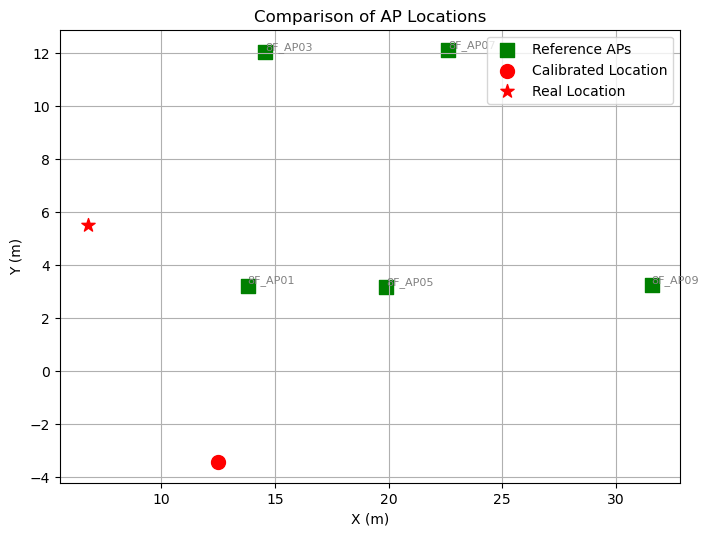

In [277]:
import matplotlib.pyplot as plt

# Create a scatter plot
fig = plt.figure()
fig, ax = plt.subplots() 
fig.set_dpi(100)
fig.set_size_inches(8, 6, forward=True)

for i, (ap, (x, y)) in enumerate(ref_aps_dict.items()):
    plt.scatter(x, y, c='green', s=100, marker='s')
    plt.text(x, y, ap, fontsize=8, ha='left', va='bottom', color='gray')


# Plot circles for trilateration
# for i, (x, y) in ref_aps_coords:
#     print(x, y)
#     circle = plt.Circle((x, y), distance_calibrated[i], color='blue', fill=False, linestyle='dashed')
#     ax.add_patch(circle)

# Plot a single label for reference APs
plt.scatter([], [], c='green', s=100, marker='s', label='Reference APs')

# Plot calibrated location
plt.scatter(position_calibrated[1], position_calibrated[2], s=100, c='red', marker='o', label='Calibrated Location')

# Plot rogue AP's real location
plt.scatter(rogue_ap_real_coords[0], rogue_ap_real_coords[1], s=100, c='red', marker='*', label='Real Location')

# Add labels and legend
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plt.xlim(0, 37)
# plt.ylim(15, -2)
plt.title('Comparison of AP Locations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
